<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

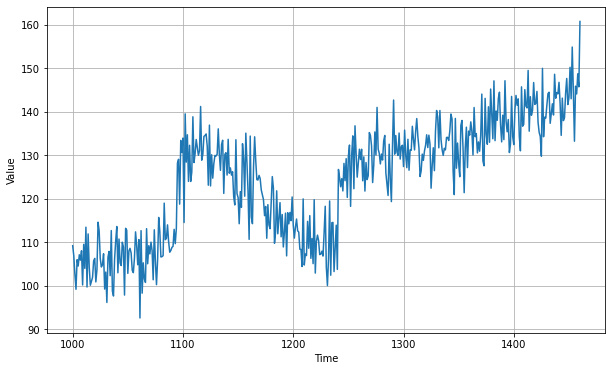

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 926.8285
Epoch 2/100
31/31 [==============================] - 0s 874us/step - loss: 109.8298
Epoch 3/100
31/31 [==============================] - 0s 734us/step - loss: 61.5885
Epoch 4/100
31/31 [==============================] - 0s 983us/step - loss: 53.3982
Epoch 5/100
31/31 [==============================] - 0s 888us/step - loss: 53.8735
Epoch 6/100
31/31 [==============================] - 0s 917us/step - loss: 55.9253
Epoch 7/100
31/31 [==============================] - 0s 870us/step - loss: 46.5764
Epoch 8/100
31/31 [==============================] - 0s 903us/step - loss: 43.0222
Epoch 9/100
31/31 [==============================] - 0s 824us/step - loss: 47.3118
Epoch 10/100
31/31 [==============================] - 0s 798us/step - loss: 40.4603
Epoch 11/100
31/31 [==============================] - 0s 896us/step - loss: 40.1821
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 42.7839
Epo

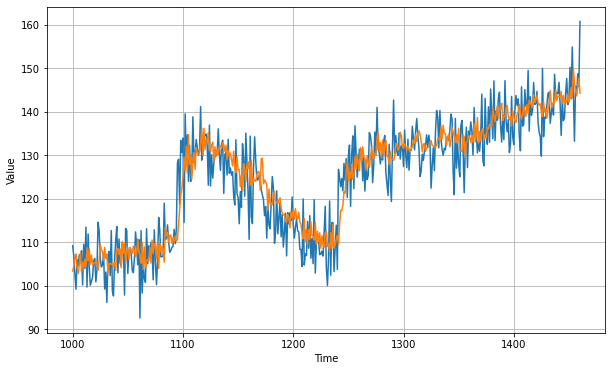

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7015305

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

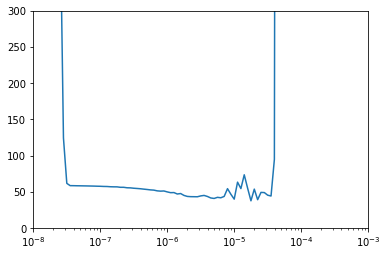

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [13]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 1ms/step - loss: 6052.3493
Epoch 2/500
31/31 [==============================] - 0s 815us/step - loss: 4260.9146
Epoch 3/500
31/31 [==============================] - 0s 856us/step - loss: 4377.7273
Epoch 4/500
31/31 [==============================] - 0s 914us/step - loss: 4250.5392
Epoch 5/500
31/31 [==============================] - 0s 939us/step - loss: 4237.4234
Epoch 6/500
31/31 [==============================] - 0s 847us/step - loss: 4183.7556
Epoch 7/500
31/31 [==============================] - 0s 786us/step - loss: 4238.7516
Epoch 8/500
31/31 [==============================] - 0s 958us/step - loss: 4010.3426
Epoch 9/500
31/31 [==============================] - 0s 888us/step - loss: 3894.2247
Epoch 10/500
31/31 [==============================] - 0s 770us/step - loss: 3803.2828
Epoch 11/500
31/31 [==============================] - 0s 934us/step - loss: 3730.0635
Epoch 12/500
31/31 [==============================] - 0s 891us/st

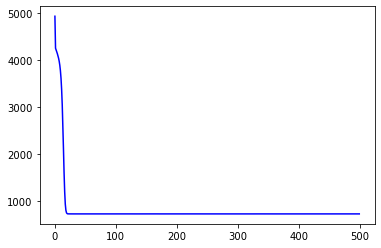

In [14]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[3606.543701171875, 3370.08984375, 3041.757080078125, 2611.029296875, 2108.915283203125, 1598.9654541015625, 1191.3043212890625, 927.8078002929688, 795.65966796875, 742.4779663085938, 725.468994140625, 720.2078247070312, 719.0677490234375, 718.9158325195312, 719.1095581054688, 718.6810913085938, 718.691650390625, 718.71044921875, 718.6251831054688, 718.7184448242188, 718.7333984375, 718.6848754882812, 718.8306884765625, 718.67236328125, 718.9149780273438, 718.669921875, 718.78662109375, 718.8425903320312, 718.6096801757812, 718.7459106445312, 718.7647094726562, 718.7183227539062, 718.7732543945312, 718.776123046875, 718.6314086914062, 718.5756225585938, 718.6176147460938, 718.9085693359375, 718.6716918945312, 718.651611328125, 718.5953979492188, 718.8236083984375, 719.0375366210938, 718.8743286132812, 718.7279663085938, 718.9419555664062, 718.94091796875, 718.9096069335938, 718.9711303710938, 718.817138671875, 718.7271728515625, 718.8180541992188, 718.919921875, 718.646240234375, 718.8

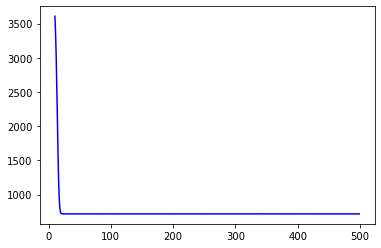

In [15]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

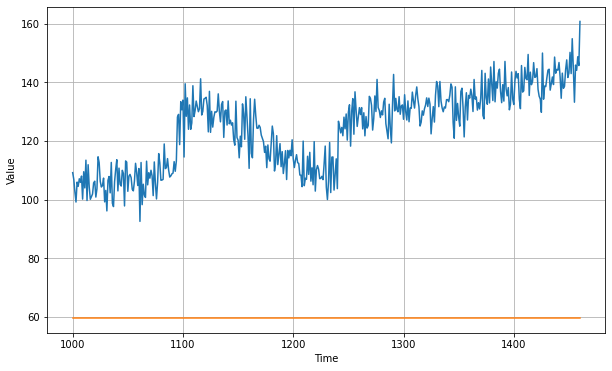

In [16]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

64.773575